# Development of ACTS detector images

Let's work on the code to produce ACTS detector images for computer-vision like tasks.

Here we will implement a per-volume binning of detector hits to produce images per sample.

In [1]:
# System
from __future__ import print_function
import os
import ast
import multiprocessing as mp

# Externals
import numpy as np
import pandas as pd
from scipy import sparse

# Locals
from data import process_hits_files, select_barrel_hits, bin_barrel_hits

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Data processing utilities

I should reuse as much as possible of my data prep stuff from the tree_search folder.

## Load the data

We're starting with a single file of mu10 data.

In [2]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'

In [3]:
all_files = os.listdir(data_dir)
hits_files = sorted(os.path.join(data_dir, f) for f in all_files if f.startswith('clusters'))

n_files = 1
hits_files = hits_files[:n_files]

In [4]:
%%time

n_workers = 1
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)
    hits = pool.map(select_barrel_hits, hits)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
CPU times: user 56.9 ms, sys: 91.9 ms, total: 149 ms
Wall time: 1min 2s


In [5]:
hits = pd.concat(hits)

In [6]:
print('Hits data shape:', hits.shape)

Hits data shape: (327771, 6)


### Average layer radius

Let's determine the average radius of each detector layer for drawing in 3D later.

In [7]:
hits.head()

,evtid,barcode,phi,z,volume,layer
5,0,9013658885554176,3.116340,-239.934006,0,0
6,0,9013658885554176,3.116865,-225.959000,0,0
7,0,9008298766368768,0.367411,-121.959000,0,0
8,0,9008298766368768,0.367519,-128.794006,0,0
9,0,9012421934972928,-0.496255,-31.854601,0,0


Oh, I don't currently have 'r' after the select_barrel_hits function is applied.
I could fix that...

## Define the binning

Start coarse

In [8]:
# Data config
vols = [0, 1, 2]
n_vols = len(vols)

# Number of bins defined per volume as (numLayer, numPhi, numZ)
bins = [
    [4, 64, 64],
    [4, 64, 64],
    [2, 64, 21]
]

# Ranges similarly defined per volume as (rangeLayer, rangePhi, rangeZ)
ranges = [
    [[0, 4], [-np.pi, np.pi], [-500, 500]],
    [[4, 8], [-np.pi, np.pi], [-1080, 1080]],
    [[8, 10], [-np.pi, np.pi], [-1031, 1031]]
]

## Construct some images

In [9]:
# Number of samples to prepare
n_samples = 4

# Unique event IDs
evtids = hits.evtid.drop_duplicates().values[:n_samples]

In [10]:
hists = bin_barrel_hits(hits, evtids=evtids, vols=vols, bins=bins, ranges=ranges)

## Projection plots

In [13]:
def draw_vol_projections(event, bins, ranges,
                         axis_labels=['Layer', '$\phi$', 'Z [mm]'],
                         figsize=(12, 3), cmap='gray_r', vmax=None):
    """Draws the 2D projections of 3D volumes"""
    nvols = len(event)
    # Get the projections - reshape for convenience
    zprojs = [event[i].reshape(bins[i]).sum(axis=1) for i in range(nvols)]
    pprojs = [event[i].reshape(bins[i]).sum(axis=2) for i in range(nvols)]
    
    plt.figure(figsize=figsize)
    imshow_args = dict(interpolation='none', aspect='auto', origin='lower',
                       cmap=cmap, vmax=vmax)
    
    # Draw Z vs. layer
    plt.subplot(121)
    vcols = ['r', 'b', 'g']
    for i in range(nvols):
        lay_range, phi_range, z_range = ranges[i]
        # Draw the detector image
        plt.imshow(zprojs[i], extent=z_range+lay_range, **imshow_args)
        # Draw some lines around the volume
        vpos = (z_range[0], lay_range[0])
        vwidth, vheight = z_range[1]-z_range[0], lay_range[1]-lay_range[0]
        plt.gca().add_patch(patches.Rectangle(vpos, vwidth, vheight,
                                              fill=False, ls=':', color=vcols[i%3]))
    plt.ylim((ranges[0][0][0], ranges[-1][0][-1]))
    plt.xlabel(axis_labels[2])
    plt.ylabel(axis_labels[0])

    # Draw phi vs. layer
    plt.subplot(122)
    for i in range(nvols):
        lay_range, phi_range, z_range = ranges[i]
        # Draw the detector image
        plt.imshow(pprojs[i], extent=phi_range+lay_range, **imshow_args)
        # Draw some lines around the volume
        vpos = (phi_range[0], lay_range[0])
        vwidth, vheight = phi_range[1]-phi_range[0], lay_range[1]-lay_range[0]
        plt.gca().add_patch(patches.Rectangle(vpos, vwidth, vheight,
                                              fill=False, ls=':', color=vcols[i%3]))
    plt.ylim((ranges[0][0][0], ranges[-1][0][-1]))
    plt.xlabel(axis_labels[1])
    plt.ylabel(axis_labels[0])
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


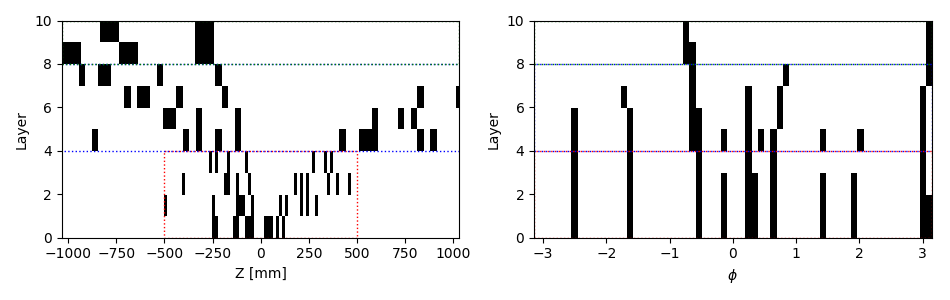

<IPython.core.display.Javascript object>


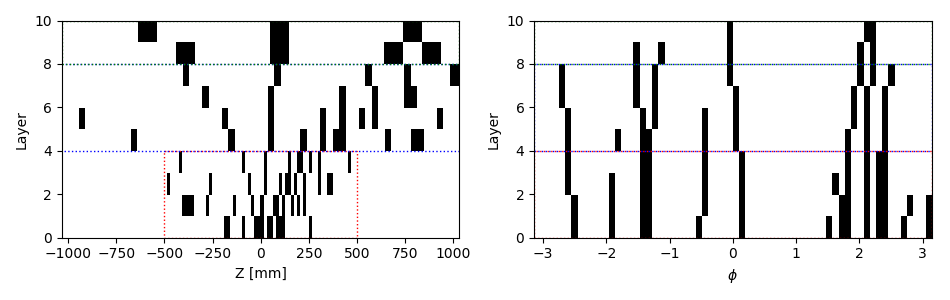

<IPython.core.display.Javascript object>


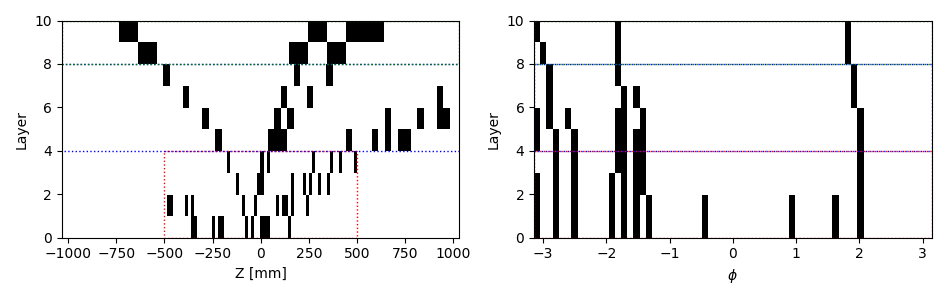

In [14]:
for i in [0, 1, 2]:
    draw_vol_projections([h[i] for h in hists], bins, ranges, figsize=(9.5,3), vmax=1)

## 3D plots

Let's try to make some cool looking plots similar to what I used to do for the 3D toy data.

In [15]:
from matplotlib import cm

<IPython.core.display.Javascript object>


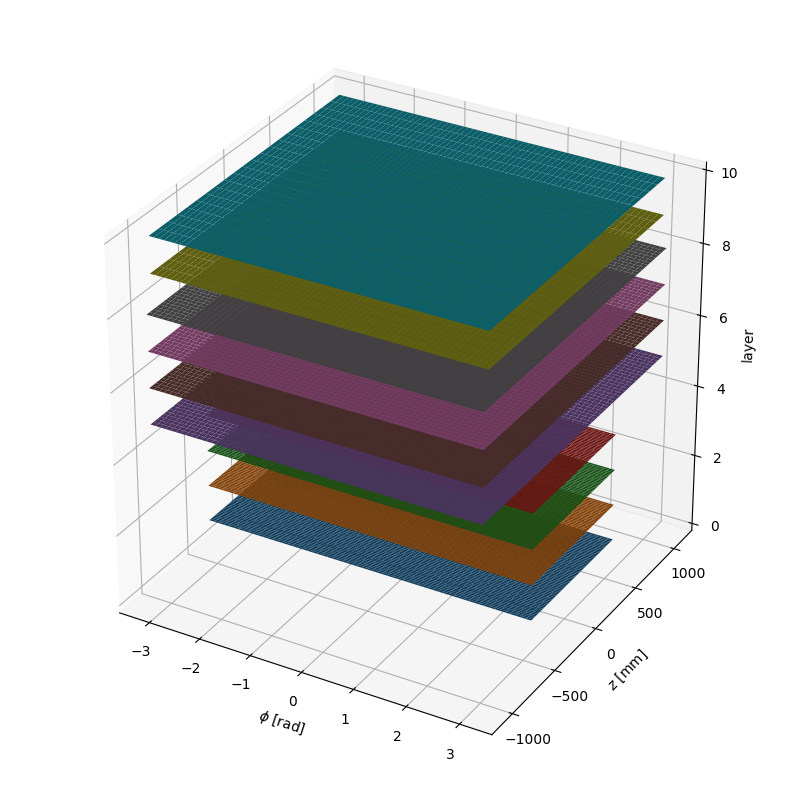

In [16]:
rhos = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10]]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over volumes
iv = 0
for iv in range(n_vols):
    phi_edges = np.linspace(*ranges[iv][1], num=bins[iv][1]+1)
    z_edges = np.linspace(*ranges[iv][2], num=bins[iv][2]+1)
    gridx, gridy = np.meshgrid(phi_edges, z_edges, indexing='ij')    

    # Loop over layers
    for il in range(bins[iv][0]):
        ax.plot_surface(gridx, gridy, rhos[iv][il], rstride=1, cstride=1)

ax.set_xlabel('$\phi$ [rad]')
ax.set_ylabel('$z$ [mm]')
ax.set_zlabel('layer')
ax.set_zlim(zmin=0)
plt.tight_layout()

<IPython.core.display.Javascript object>


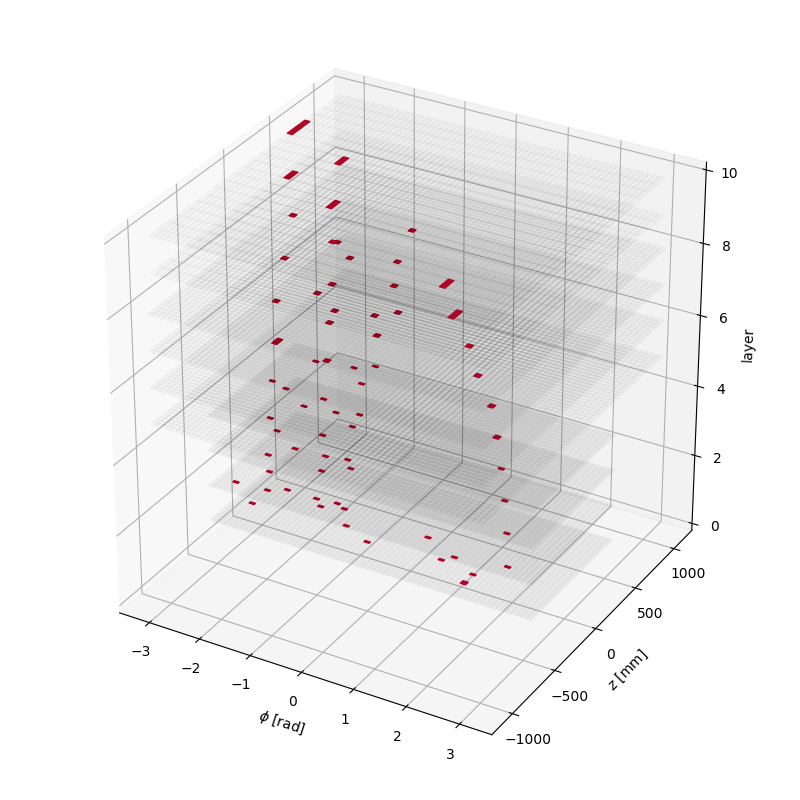

In [33]:
cmap = cm.get_cmap('coolwarm')
alpha = 1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over volumes
iv = 0
for iv in range(n_vols):
    phi_edges = np.linspace(*ranges[iv][1], num=bins[iv][1]+1)
    z_edges = np.linspace(*ranges[iv][2], num=bins[iv][2]+1)
    gridx, gridy = np.meshgrid(phi_edges, z_edges, indexing='ij')    

    # Loop over layers
    for il in range(bins[iv][0]):
        h = hists[iv][i,il].astype(np.float32)
        colors = cmap(h, alpha=alpha)
        # Make zeros invisible
        colors[h < 0.1, :] = 0.02
        ax.plot_surface(gridx, gridy, rhos[iv][il], rstride=1, cstride=1,
                        facecolors=colors, shade=False)

ax.set_xlabel('$\phi$ [rad]')
ax.set_ylabel('$z$ [mm]')
ax.set_zlabel('layer')
ax.set_zlim(zmin=0)
plt.tight_layout()

## Sparse representation

Figure out how to switch between dense and sparse representations. Use the sparse rep for serialization (if straightforward).

There are some sparse structures and routines here: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [ ]:
# Reshape and sparsify
sparse_hists = [sparse.coo_matrix(h.reshape((n_samples, -1)))
                for h in hists]

In [107]:
sh = sparse_hists[0]

In [118]:
# Convert back into dense histogram
sh.toarray().reshape([n_samples] + bins[0]).shape

(8, 4, 64, 64)

In [108]:
# Save the sparse data to file
sparse.save_npz('temp.npz', sh)

# Save the binning with the data
np.savez('binning.npz', bins=bins, ranges=ranges)

## Still to do

- Detector occupancy plots